In [1]:
# Handle imports

import torch
import copy
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Module
from torch.nn.utils import parametrize
from torch.nn.utils.parametrizations import _SpectralNorm
from torch.nn.functional import normalize, conv_transpose2d, conv2d
from torch.nn.utils.spectral_norm import (
    SpectralNorm,
    SpectralNormLoadStateDictPreHook,
    SpectralNormStateDictHook,
)

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# At first defining a basic neural network that has one layer and uses implementation from uncertainty-research

class SpectralNormConv2d(nn.Module):
    def __init__(self,
                 weight: torch.Tensor,
                 input_shape: torch.Tensor,
                 output_shape: torch.Tensor,
                 stride: tuple,
                 padding: int,
                 norm_bound: float = 1,
                 n_power_iterations: int = 1,
                 dim: int = 0,
                 eps: float = 1e-12):
        super().__init__()
        self.norm_bound = norm_bound

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.stride = stride
        self.padding = padding

        ndim = weight.ndim
        if dim >= ndim or dim < -ndim:
            raise IndexError("Dimension out of range (expected to be in range of "
                             f"[-{ndim}, {ndim - 1}] but got {dim})")

        if n_power_iterations <= 0:
            raise ValueError('Expected n_power_iterations to be positive, but '
                             'got n_power_iterations={}'.format(n_power_iterations))

        self.dim = dim if dim >= 0 else dim + ndim
        self.eps = eps
        if ndim > 1:
            # For ndim == 1 we do not need to approximate anything (see _SpectralNorm.forward)
            self.n_power_iterations = n_power_iterations

            v = torch.randn(self.input_shape).to(weight.device)
            v_ = F.normalize(v.view(-1), dim=0, eps=self.eps)
            v = v_.view(v.shape)

            u = F.conv2d(
                v, weight, stride=stride, padding=padding, bias=None
            )
            #u = torch.randn(self.output_shape).to(weight.device)
            
            u_ = F.normalize(u.view(-1), dim=0, eps=self.eps)
            u = u_.view(u.shape)

            self.register_buffer('_v', v)
            self.register_buffer('_u', u)
            #self._power_method(weight, 15)
            # self._u.mean(), self._u.std()

    @torch.autograd.no_grad()
    def _power_method(self, weight_mat: torch.Tensor, n_power_iterations: int) -> None:
        # Does not support Dataparallel, see comment in pytorch implementation
        assert weight_mat.ndim > 1

        u_hat = getattr(self, '_u')
        v_hat = getattr(self, '_v')

        for _ in range(n_power_iterations):
            v_ = F.conv_transpose2d(u_hat, weight_mat, stride=self.stride, padding=self.padding)
            v_hat = F.normalize(v_.view(1, -1))
            v_hat = v_hat.view(v_.shape)

            u_ = F.conv2d(v_hat, weight_mat, stride=self.stride, padding=self.padding)
            u_hat = F.normalize(u_.view(1, -1))
            u_hat = u_hat.view(u_.shape)

        setattr(self, '_u', u_hat)
        setattr(self, '_v', v_hat)

    def forward(self, weight: torch.Tensor) -> torch.Tensor:
        if self.training:
            self._power_method(weight, self.n_power_iterations)
        u = self._u.clone(memory_format=torch.contiguous_format)
        v = self._v.clone(memory_format=torch.contiguous_format)

        v_w_hat = F.conv2d(v, weight, stride=self.stride, padding=self.padding)
        sigma = torch.matmul(v_w_hat.view(1, -1), u.view(-1, 1))
        sigma = sigma.squeeze()

        factor = torch.max(torch.ones(1, device=weight.device), sigma / self.norm_bound)
        weight_norm = weight / factor

        return weight_norm


def spectral_norm_conv2d(module: Module,
                         input_shape: tuple,
                         output_shape: tuple,
                         stride: tuple,
                         padding: int,
                         norm_bound: float,
                         name='weight',
                         n_power_iterations=1,
                         eps=1e-12,
                         dim=None):
    weight = getattr(module, name, None)
    if not isinstance(weight, torch.Tensor):
        raise ValueError("Module '{}' has no parameter or buffer with name '{}'".format(module, name))
    if dim is None:
        if isinstance(module, (torch.nn.ConvTranspose1d, torch.nn.ConvTranspose2d, torch.nn.ConvTranspose3d)):
            dim = 1
        else:
            dim = 0
    parametrize.register_parametrization(
        module,
        name,
        SpectralNormConv2d(weight, input_shape, output_shape, stride, padding, norm_bound, n_power_iterations, dim, eps)
        # SpectralNormLinear(weight, norm_bound, n_power_iterations, dim, eps)
    )
    return module


class SpectralConv2d(nn.Conv2d):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size,
                 spectral_norm=True,
                 norm_bound=1,
                 n_power_iterations=1,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups: int = 1,
                 bias: bool = True,
                 padding_mode: str = 'zeros',
                 device=None,
                 dtype=None) -> None:
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
            device,
            dtype
        )
        # Apply spectral norm after init
        self.norm_bound = norm_bound
        self.n_power_iterations = n_power_iterations
        self.spectral_norm = spectral_norm
        self.spectral_norm_added = False

    def add_spectral_norm_conv2d(self, input):
        if self.spectral_norm:
            # Determine shapes
            in_channel, in_height, in_width = input.shape[1:]

            out_channel = self.out_channels
            out_height = in_height // self.stride[0]
            out_width = in_width // self.stride[1]

            input_shape = (1, in_channel, in_height, in_width)
            output_shape = (1, out_channel, out_height, out_width)

            spectral_norm_conv2d(
                module=self,
                input_shape=input_shape,
                output_shape=output_shape,
                stride=self.stride,
                padding=self.padding,
                norm_bound=self.norm_bound,
                n_power_iterations=self.n_power_iterations,
            )
            self.spectral_norm_added = True

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if not self.spectral_norm_added:
            self.add_spectral_norm_conv2d(input)
        return super().forward(input)
    
    
class BasicConvNetA(Module):
    def __init__(self, conv_layer, fc_layer, coeff, n_power_iter):
        super(BasicConvNetA, self).__init__()
        self.layer1 = SpectralConv2d(
            in_channels=1,
            out_channels=conv_layer.out_channels,
            kernel_size=(3,3), 
            norm_bound=coeff,
            n_power_iterations=n_power_iter,
        )
        self.layer1.load_state_dict(conv_layer.state_dict())
        self.fc = fc_layer
        self.act = torch.relu
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.act(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def show_weight_norm(self):
        return torch.linalg.matrix_norm(self.layer1.weight, 2)

In [3]:
# Implementation from DUE (https://github.com/y0ast/DUE/blob/main/due/layers/spectral_norm_conv.py)

class SpectralNormConv(SpectralNorm):
    def compute_weight(self, module, do_power_iteration: bool) -> torch.Tensor:
        weight = getattr(module, self.name + "_orig")
        u = getattr(module, self.name + "_u")
        v = getattr(module, self.name + "_v")

        # get settings from conv-module (for transposed convolution parameters)
        stride = module.stride
        padding = module.padding

        if do_power_iteration:
            with torch.no_grad():
                output_padding = 0
                if stride[0] > 1:
                    # Note: the below does not generalize to stride > 2
                    output_padding = 1 - self.input_dim[-1] % 2

                for _ in range(self.n_power_iterations):
                    v_s = conv_transpose2d(
                        u.view(self.output_dim),
                        weight,
                        stride=stride,
                        padding=padding,
                        output_padding=output_padding,
                    )
                    v = normalize(v_s.view(-1), dim=0, eps=self.eps, out=v)

                    u_s = conv2d(
                        v.view(self.input_dim),
                        weight,
                        stride=stride,
                        padding=padding,
                        bias=None,
                    )
                    u = normalize(u_s.view(-1), dim=0, eps=self.eps, out=u)
                if self.n_power_iterations > 0:
                    # See above on why we need to clone
                    u = u.clone(memory_format=torch.contiguous_format)
                    v = v.clone(memory_format=torch.contiguous_format)

        weight_v = conv2d(
            v.view(self.input_dim), weight, stride=stride, padding=padding, bias=None
        )
        weight_v = weight_v.view(-1)
        sigma = torch.dot(u.view(-1), weight_v)
        # soft normalization: only when sigma larger than coeff
        factor = torch.max(torch.ones(1, device=weight.device), sigma / self.coeff)
        weight = weight / factor

        # for logging
        sigma_log = getattr(module, self.name + "_sigma")
        sigma_log.copy_(sigma.detach())

        return weight

    def __call__(self, module, inputs):
        assert (
            inputs[0].shape[1:] == self.input_dim[1:]
        ), "Input dims don't match actual input"
        setattr(
            module,
            self.name,
            self.compute_weight(module, do_power_iteration=module.training),
        )

    @staticmethod
    def apply(module, coeff, input_dim, name, n_power_iterations, eps):
        for k, hook in module._forward_pre_hooks.items():
            if isinstance(hook, SpectralNormConv) and hook.name == name:
                raise RuntimeError(
                    "Cannot register two spectral_norm hooks on "
                    "the same parameter {}".format(name)
                )

        fn = SpectralNormConv(name, n_power_iterations, eps=eps)
        fn.coeff = coeff
        fn.input_dim = input_dim
        weight = module._parameters[name]

        with torch.no_grad():
            num_input_dim = input_dim[0] * input_dim[1] * input_dim[2] * input_dim[3]
            v = normalize(torch.randn(num_input_dim), dim=0, eps=fn.eps)

            # get settings from conv-module (for transposed convolution)
            stride = module.stride
            padding = module.padding
            # forward call to infer the shape
            u = conv2d(
                v.view(input_dim), weight, stride=stride, padding=padding, bias=None
            )
            fn.output_dim = u.shape
            num_output_dim = (
                fn.output_dim[0]
                * fn.output_dim[1]
                * fn.output_dim[2]
                * fn.output_dim[3]
            )
            # overwrite u with random init
            u = normalize(torch.randn(num_output_dim), dim=0, eps=fn.eps)

        delattr(module, fn.name)
        module.register_parameter(fn.name + "_orig", weight)
        setattr(module, fn.name, weight.data)
        module.register_buffer(fn.name + "_u", u)
        module.register_buffer(fn.name + "_v", v)
        module.register_buffer(fn.name + "_sigma", torch.ones(1))

        module.register_forward_pre_hook(fn)

        module._register_state_dict_hook(SpectralNormStateDictHook(fn))
        module._register_load_state_dict_pre_hook(SpectralNormLoadStateDictPreHook(fn))
        return fn


def spectral_norm_conv(
    module, coeff, input_dim, n_power_iterations=1, name="weight", eps=1e-12,
):
    """
    Applies spectral normalization to Convolutions with flexible max norm
    Args:
        module (nn.Module): containing convolution module
        input_dim (tuple(int, int, int)): dimension of input to convolution
        coeff (float, optional): coefficient to normalize to
        n_power_iterations (int, optional): number of power iterations to
            calculate spectral norm
        name (str, optional): name of weight parameter
        eps (float, optional): epsilon for numerical stability in
            calculating norms
    Returns:
        The original module with the spectral norm hook
    Example::
        >>> m = spectral_norm_conv(nn.Conv2D(3, 16, 3), (3, 32, 32), 2.0)
    """

    input_dim_4d = torch.Size([1, input_dim[0], input_dim[1], input_dim[2]])
    SpectralNormConv.apply(module, coeff, input_dim_4d, name, n_power_iterations, eps)

    return module


class BasicConvNetB(Module):
    def __init__(self, conv_layer, fc_layer, coeff, n_power_iter):
        super(BasicConvNetB, self).__init__()
        self.layer1 = spectral_norm_conv(
            module=conv_layer, 
            coeff=coeff,
            input_dim=(1,28,28),
            n_power_iterations=n_power_iter,
        )
        self.fc = fc_layer
        self.act = torch.relu
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.act(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def show_weight_norm(self):
        return torch.linalg.matrix_norm(self.layer1.weight, 2)

In [4]:
# Defining a simple Training Method

def train_one_epoch_conv(model, optimizer, criterion, dataloader):
    model = model.train()
    
    total_loss, num_samples = 0, 0
    
    for samples, targets in dataloader:
        out = model(samples)
        loss = criterion(out, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_size = out.shape[0]
        total_loss += loss.item() * batch_size
        num_samples += batch_size
        
    return total_loss/num_samples

Modell A Loss: 2.2328033447265625     Modell B Loss: 2.235513687133789


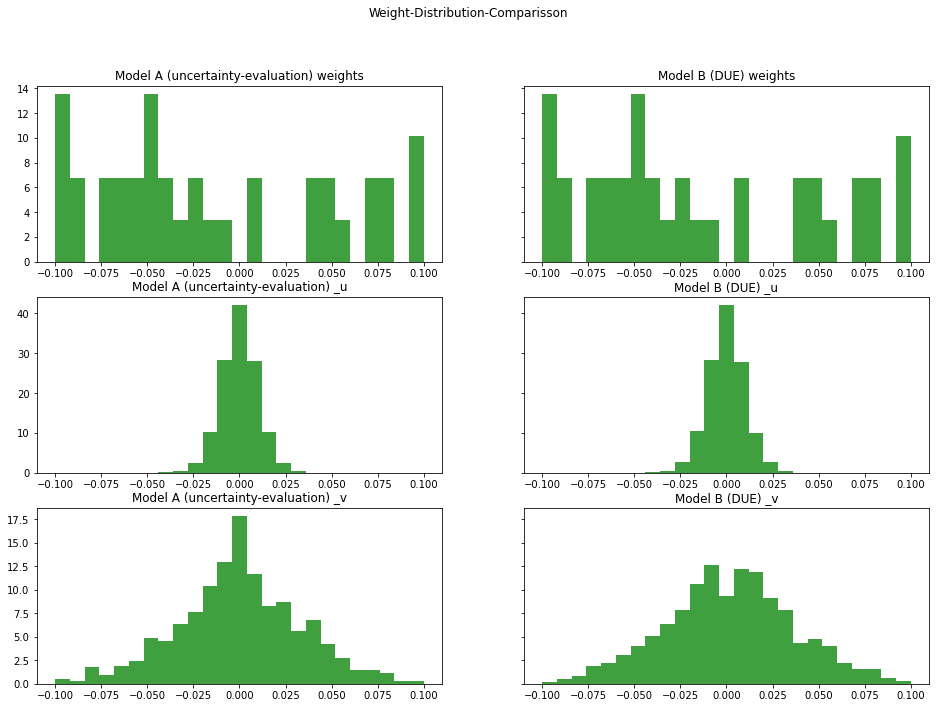

Modell A Loss: 1.5057129859924316     Modell B Loss: 1.460026502609253


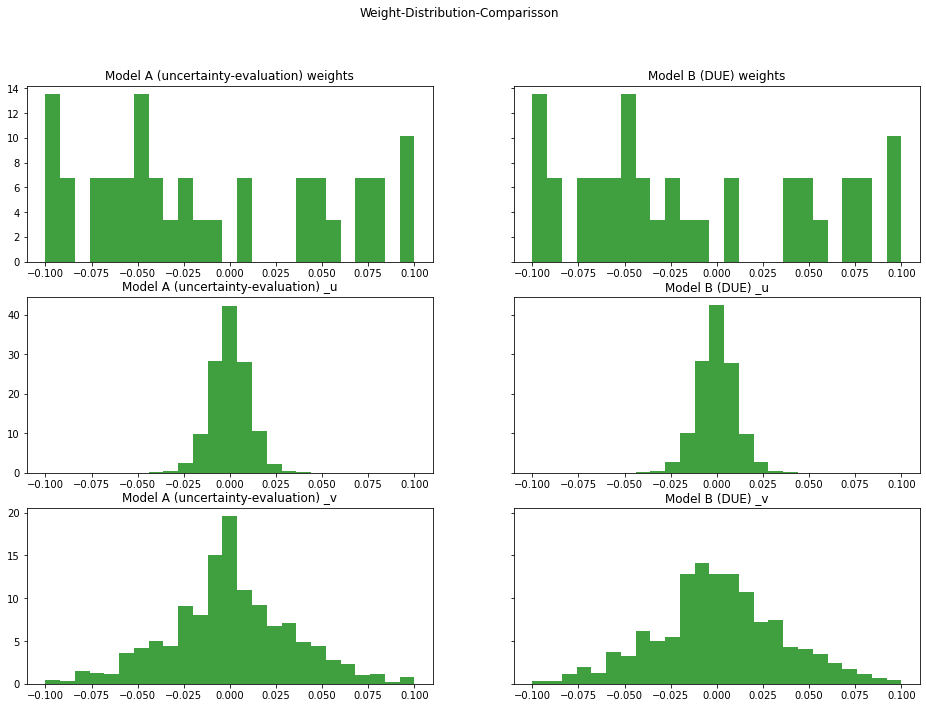

Modell A Loss: 0.7051701545715332     Modell B Loss: 0.6562826037406921


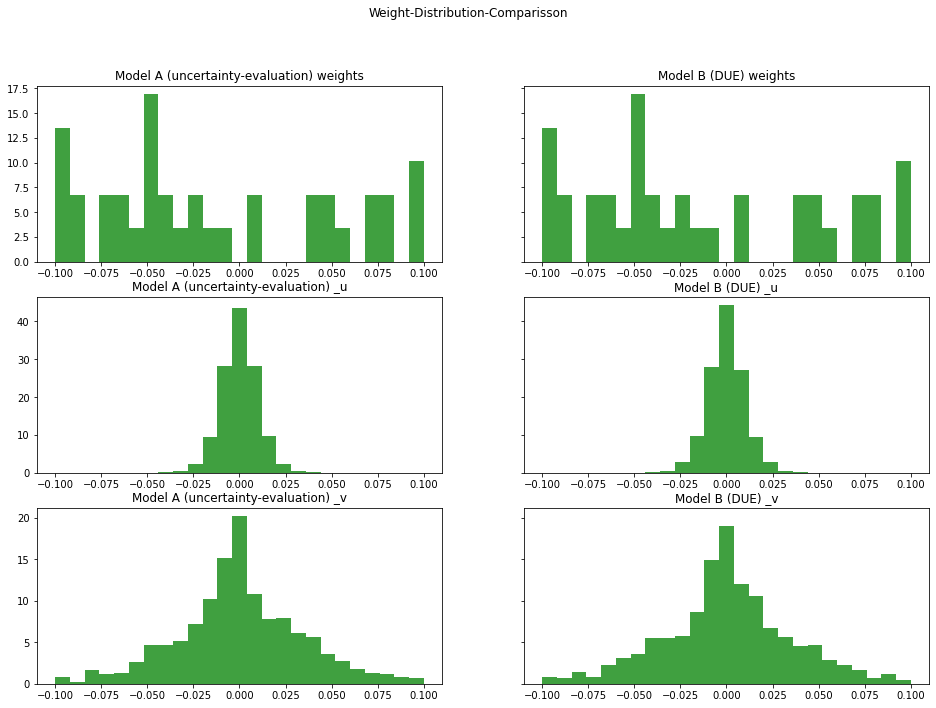

Modell A Loss: 0.30216482281684875     Modell B Loss: 0.2738760709762573


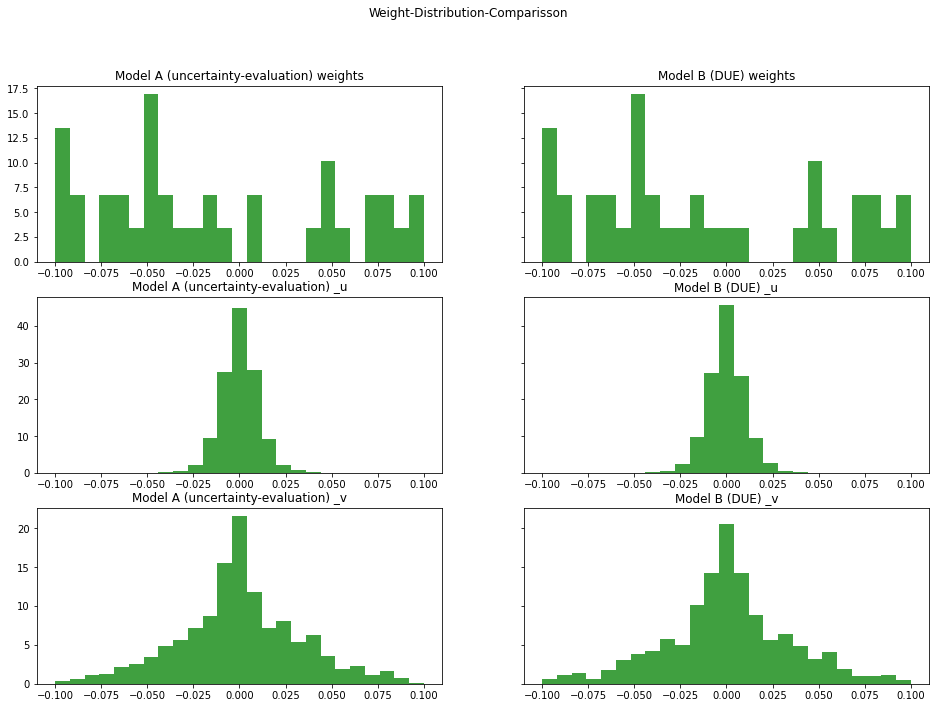

Modell A Loss: 0.13935112953186035     Modell B Loss: 0.12443090975284576


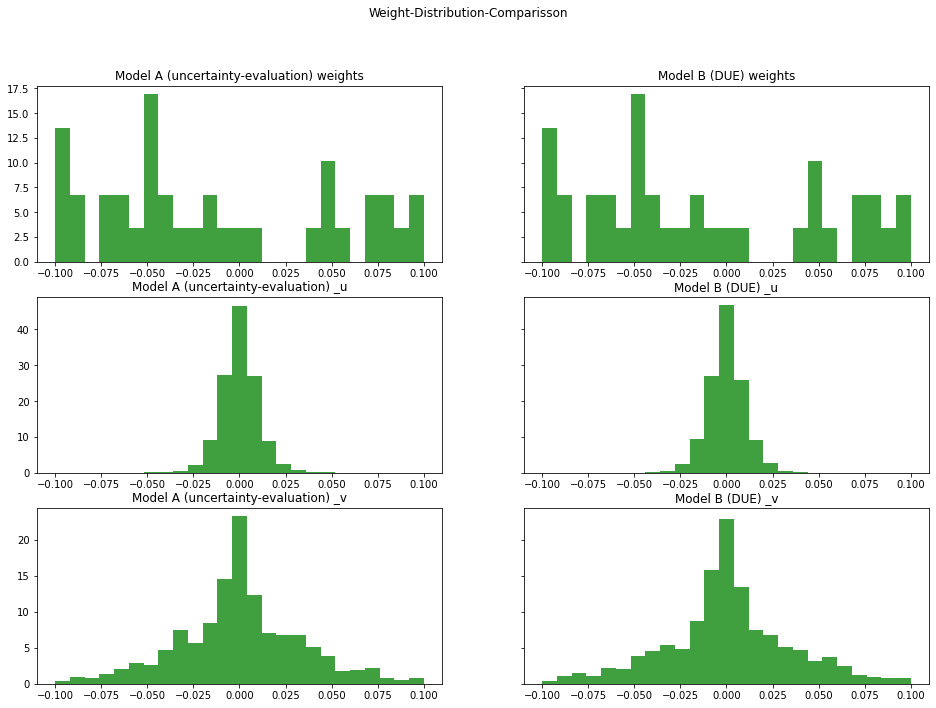

In [5]:
# Define necessary parameters and train
criterion = nn.CrossEntropyLoss()
num_out_channels = 15
num_epochs = 5
lr = 5e-3
weight_decay = 1e-5
momentum = 0.9

coeff = 0.95
n_power_iter = 1

# Define a Dataset and it's matching Loader

ds = datasets.MNIST('./ds', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))

ss = Subset(ds,[0,1000])

data_loader = torch.utils.data.DataLoader(
    ss,
    batch_size=32)

# Predefine Layers for equal param start
conv_layer = nn.Conv2d(1,num_out_channels,(3,3))
fc_layer = nn.Linear(676 * num_out_channels ,10)

# Define Models each using one of the spectral normalization variants
model_A = BasicConvNetA(copy.deepcopy(conv_layer), copy.deepcopy(fc_layer), coeff, n_power_iter)

optimizer_A = torch.optim.SGD(
            model_A.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum
        )

model_B = BasicConvNetB(copy.deepcopy(conv_layer), copy.deepcopy(fc_layer), coeff, n_power_iter)

optimizer_B = torch.optim.SGD(
            model_B.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum
        )

# Train and plot loss comparisson aswell as weight distributions
num_bins = 25
hist_range = (-0.1,0.1)

for i in range(num_epochs):
    loss_A = train_one_epoch_conv(model_A, optimizer_A, criterion, data_loader)
    loss_B = train_one_epoch_conv(model_B, optimizer_B, criterion, data_loader)
    print("Modell A Loss:",loss_A, "    Modell B Loss:",loss_B)
    #print("Modell A Weight Norm:", model_A.show_weight_norm(), "    Modell B Weight Norm:",model_B.show_weight_norm())
    
    fig, axs = plt.subplots(
        nrows=3,
        ncols=2,
        sharey='row', 
        figsize=(16,11)
    )
    fig.suptitle('Weight-Distribution-Comparisson')

    #Original Weights
    weights_A_u = model_A.state_dict()['layer1.parametrizations.weight.original']
    weights_A_u = weights_A_u.view(weights_A_u.size(0), -1)
    weights_A_u = weights_A_u.view(1, weights_A_u.size(0)*weights_A_u.size(1))
    axs[0][0].hist(weights_A_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[0][0].title.set_text('Model A (uncertainty-evaluation) weights')
    
    weights_B_u = model_B.state_dict()['layer1.weight_orig']
    weights_B_u = weights_B_u.view(weights_B_u.size(0), -1)
    weights_B_u = weights_B_u.view(1, weights_B_u.size(0)*weights_B_u.size(1))
    axs[0][1].hist(weights_B_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[0][1].title.set_text('Model B (DUE) weights')
    

    #_u
    weights_A_u = model_A.state_dict()['layer1.parametrizations.weight.0._u']
    weights_A_u = weights_A_u.view(weights_A_u.size(0), -1)
    weights_A_u = weights_A_u.view(1, weights_A_u.size(0)*weights_A_u.size(1))
    axs[1][0].hist(weights_A_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[1][0].title.set_text('Model A (uncertainty-evaluation) _u')
    
    weights_B_u = model_B.state_dict()['layer1.weight_u']
    weights_B_u = weights_B_u.view(weights_B_u.size(0), -1)
    weights_B_u = weights_B_u.view(1, weights_B_u.size(0)*weights_B_u.size(1))
    axs[1][1].hist(weights_B_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[1][1].title.set_text('Model B (DUE) _u')


    #_v
    weights_A_v = model_A.state_dict()['layer1.parametrizations.weight.0._v']
    weights_A_v = weights_A_v.view(weights_A_v.size(0), -1)
    weights_A_v = weights_A_v.view(1, weights_A_v.size(0)*weights_A_v.size(1))
    axs[2][0].hist(weights_A_v, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[2][0].title.set_text('Model A (uncertainty-evaluation) _v')
    
    weights_B_v = model_B.state_dict()['layer1.weight_v']
    weights_B_v = weights_B_v.view(weights_B_v.size(0), -1)
    weights_B_v = weights_B_v.view(1, weights_B_v.size(0)*weights_B_v.size(1))
    axs[2][1].hist(weights_B_v, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[2][1].title.set_text('Model B (DUE) _v')

    plt.show()

In [6]:
# Spectral Norm Linear Case from UE

class SpectralNormLinear(_SpectralNorm):
    def __init__(self,
                 weight: torch.Tensor,
                 norm_bound: float = 1,
                 n_power_iterations: int = 1,
                 dim: int = 0,
                 eps: float = 1e-12):
        super().__init__(weight, n_power_iterations, dim, eps)
        self.norm_bound = norm_bound

    def forward(self, weight: torch.Tensor) -> torch.Tensor:
        if weight.ndim == 1:
            # Faster and more exact path, no need to approximate anything
            return F.normalize(weight, dim=0, eps=self.eps)
        else:
            weight_mat = self._reshape_weight_to_matrix(weight)
            if self.training:
                self._power_method(weight_mat, self.n_power_iterations)
            # See above on why we need to clone
            u = self._u.clone(memory_format=torch.contiguous_format)
            v = self._v.clone(memory_format=torch.contiguous_format)
            # The proper way of computing this should be through F.bilinear, but
            # it seems to have some efficiency issues:
            # https://github.com/pytorch/pytorch/issues/58093
            sigma = torch.dot(u, torch.mv(weight_mat, v))

            # slower version: weight_norm = torch.where((self.norm_bound / sigma) < 1, (self.norm_bound / sigma) * weight, weight)

            factor = torch.max(torch.ones(1, device=weight.device), sigma / self.norm_bound)
            weight_norm = weight / factor

            return weight_norm


def spectral_norm_linear(module: Module, norm_bound: float, name='weight', n_power_iterations=1, eps=1e-12, dim=None):
    weight = getattr(module, name, None)
    if not isinstance(weight, torch.Tensor):
        raise ValueError(
            "Module '{}' has no parameter or buffer with name '{}'".format(module, name)
        )

    if dim is None:
        if isinstance(module, (torch.nn.ConvTranspose1d,
                               torch.nn.ConvTranspose2d,
                               torch.nn.ConvTranspose3d)):
            dim = 1
        else:
            dim = 0
    parametrize.register_parametrization(
        module,
        name,
        SpectralNormLinear(weight, norm_bound, n_power_iterations, dim, eps)
    )
    return module


class SpectralLinear(nn.Linear):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 spectral_norm=True,
                 norm_bound=1,
                 n_power_iterations=1,
                 bias: bool = True,
                 device=None,
                 dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        # Apply spectral norm after init
        self.norm_bound = norm_bound
        self.n_power_iterations = n_power_iterations
        if spectral_norm:
            spectral_norm_linear(self, norm_bound=self.norm_bound, n_power_iterations=self.n_power_iterations)


class BasicNetA(Module):
    def __init__(self, linear_layer1, linear_layer2, coeff, n_power_iter):
        super(BasicNetA, self).__init__()
        self.layer1 = SpectralLinear(
            in_features=784,
            out_features=200,
            norm_bound=coeff,
            n_power_iterations=n_power_iter,
        )
        self.layer1.parametrizations.weight.original = torch.nn.Parameter(linear_layer1.state_dict()["weight"])
        self.layer2 = linear_layer2
        self.act = torch.relu
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.act(out)
        out = self.layer2(out)
        return out

    def show_weight_norm(self):
        return torch.linalg.matrix_norm(self.layer1.weight, 2)

In [7]:
# Spectral Norm Implementation from DUE https://github.com/y0ast/DUE/blob/main/due/layers/spectral_norm_fc.py

class SpectralNormFC(SpectralNorm):
    def compute_weight(self, module, do_power_iteration: bool) -> torch.Tensor:
        weight = getattr(module, self.name + "_orig")
        u = getattr(module, self.name + "_u")
        v = getattr(module, self.name + "_v")
        weight_mat = self.reshape_weight_to_matrix(weight)

        if do_power_iteration:
            with torch.no_grad():
                for _ in range(self.n_power_iterations):
                    # Spectral norm of weight equals to `u^T W v`, where `u` and `v`
                    # are the first left and right singular vectors.
                    # This power iteration produces approximations of `u` and `v`.
                    v = normalize(
                        torch.mv(weight_mat.t(), u), dim=0, eps=self.eps, out=v
                    )
                    u = normalize(torch.mv(weight_mat, v), dim=0, eps=self.eps, out=u)
                if self.n_power_iterations > 0:
                    # See above on why we need to clone
                    u = u.clone(memory_format=torch.contiguous_format)
                    v = v.clone(memory_format=torch.contiguous_format)

        sigma = torch.dot(u, torch.mv(weight_mat, v))
        # soft normalization: only when sigma larger than coeff
        factor = torch.max(torch.ones(1).to(weight.device), sigma / self.coeff)
        weight = weight / factor

        # for logging
        sigma_log = getattr(module, self.name + "_sigma")
        sigma_log.copy_(sigma.detach())

        return weight

    @staticmethod
    def apply(
        module: nn.Module,
        coeff: float,
        name: str,
        n_power_iterations: int,
        dim: int,
        eps: float,
    ) -> "SpectralNormFC":
        for k, hook in module._forward_pre_hooks.items():
            if isinstance(hook, SpectralNorm) and hook.name == name:
                raise RuntimeError(
                    "Cannot register two spectral_norm hooks on "
                    "the same parameter {}".format(name)
                )

        fn = SpectralNormFC(name, n_power_iterations, dim, eps)
        fn.coeff = coeff

        weight = module._parameters[name]
        with torch.no_grad():
            weight_mat = fn.reshape_weight_to_matrix(weight)
            h, w = weight_mat.size()
            # randomly initialize `u` and `v`
            u = normalize(weight.new_empty(h).normal_(0, 1), dim=0, eps=fn.eps)
            v = normalize(weight.new_empty(w).normal_(0, 1), dim=0, eps=fn.eps)
        delattr(module, fn.name)
        module.register_parameter(fn.name + "_orig", weight)
        # We still need to assign weight back as fn.name because all sorts of
        # things may assume that it exists, e.g., when initializing weights.
        # However, we can't directly assign as it could be an nn.Parameter and
        # gets added as a parameter. Instead, we register weight.data as a plain
        # attribute.
        setattr(module, fn.name, weight.data)
        module.register_buffer(fn.name + "_u", u)
        module.register_buffer(fn.name + "_v", v)
        module.register_buffer(fn.name + "_sigma", torch.ones(1))

        module.register_forward_pre_hook(fn)
        module._register_state_dict_hook(SpectralNormStateDictHook(fn))
        module._register_load_state_dict_pre_hook(SpectralNormLoadStateDictPreHook(fn))
        return fn


def spectral_norm_fc(
    module,
    coeff: float,
    n_power_iterations: int = 1,
    name: str = "weight",
    eps: float = 1e-12,
    dim: int = None,
):
    """
    Args:
        module (nn.Module): containing module
        coeff (float, optional): coefficient to normalize to
        n_power_iterations (int, optional): number of power iterations to
            calculate spectral norm
        name (str, optional): name of weight parameter
        eps (float, optional): epsilon for numerical stability in
            calculating norms
        dim (int, optional): dimension corresponding to number of outputs,
            the default is ``0``, except for modules that are instances of
            ConvTranspose{1,2,3}d, when it is ``1``
    Returns:
        The original module with the spectral norm hook
    Example::
        >>> m = spectral_norm_fc(nn.Linear(20, 40), 2.0)
        >>> m
        Linear(in_features=20, out_features=40, bias=True)
        >>> m.weight_u.size()
        torch.Size([40])
    """
    if dim is None:
        if isinstance(
            module,
            (
                torch.nn.ConvTranspose1d,
                torch.nn.ConvTranspose2d,
                torch.nn.ConvTranspose3d,
            ),
        ):
            dim = 1
        else:
            dim = 0
    SpectralNormFC.apply(module, coeff, name, n_power_iterations, dim, eps)
    return module


class BasicNetB(Module):
    def __init__(self, linear_layer1, linear_layer2, coeff, n_power_iter):
        super(BasicNetB, self).__init__()
        self.layer1 = spectral_norm_fc(
            module=linear_layer1,
            coeff=coeff,
            n_power_iterations=n_power_iter,
        )
        self.layer2 = linear_layer2
        self.act = torch.relu
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.act(out)
        out = self.layer2(out)
        return out

    def show_weight_norm(self):
        return torch.linalg.matrix_norm(self.layer1.weight, 2)

In [8]:
# Defining a simple Training Method

def train_one_epoch(model, optimizer, criterion, dataloader):
    model = model.train()
    
    total_loss, num_samples = 0, 0
    
    for samples, targets in dataloader:
        samples = samples.view(-1, 28*28)
        out = model(samples)
        loss = criterion(out, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_size = out.shape[0]
        total_loss += loss.item() * batch_size
        num_samples += batch_size
        
    return total_loss/num_samples

Modell A Loss: 2.2768125534057617     Modell B Loss: 2.2819180488586426


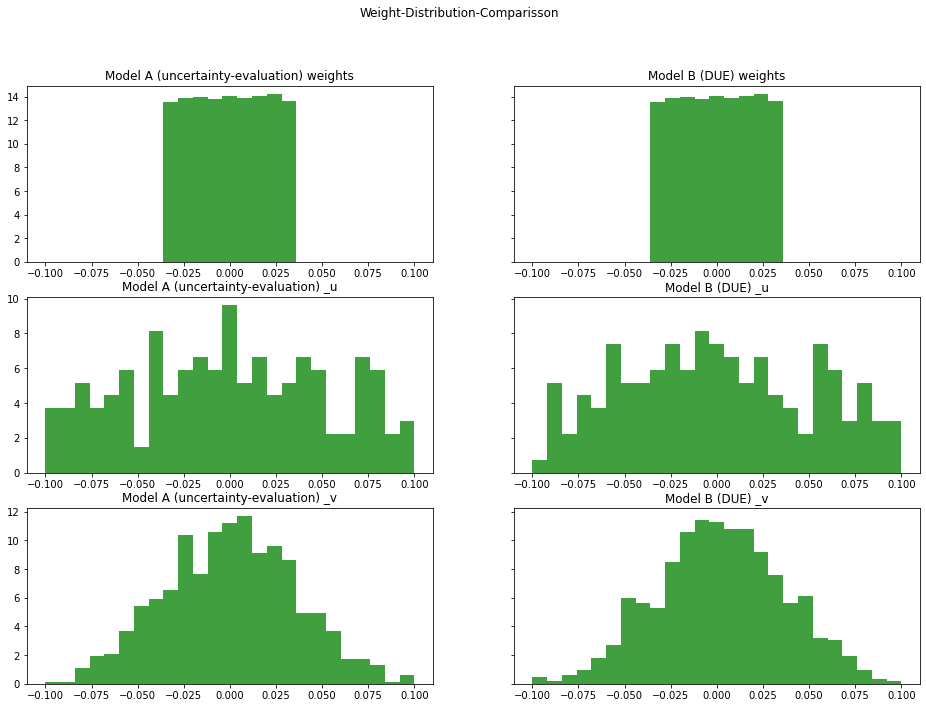

Modell A Loss: 1.918149709701538     Modell B Loss: 1.9183976650238037


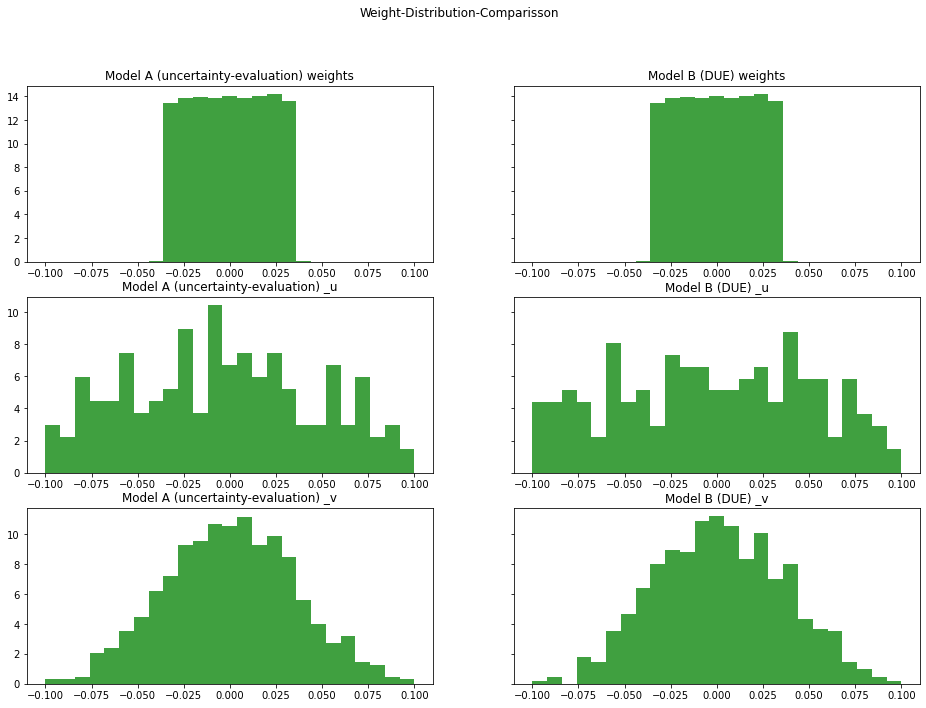

Modell A Loss: 1.3558077812194824     Modell B Loss: 1.3544797897338867


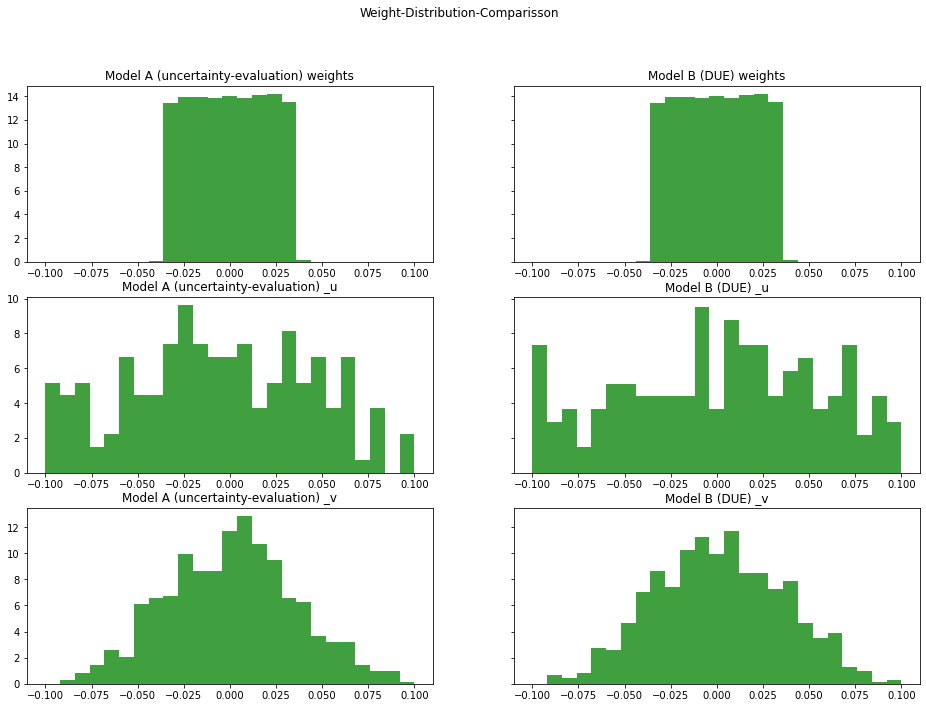

Modell A Loss: 0.8039621710777283     Modell B Loss: 0.8017168641090393


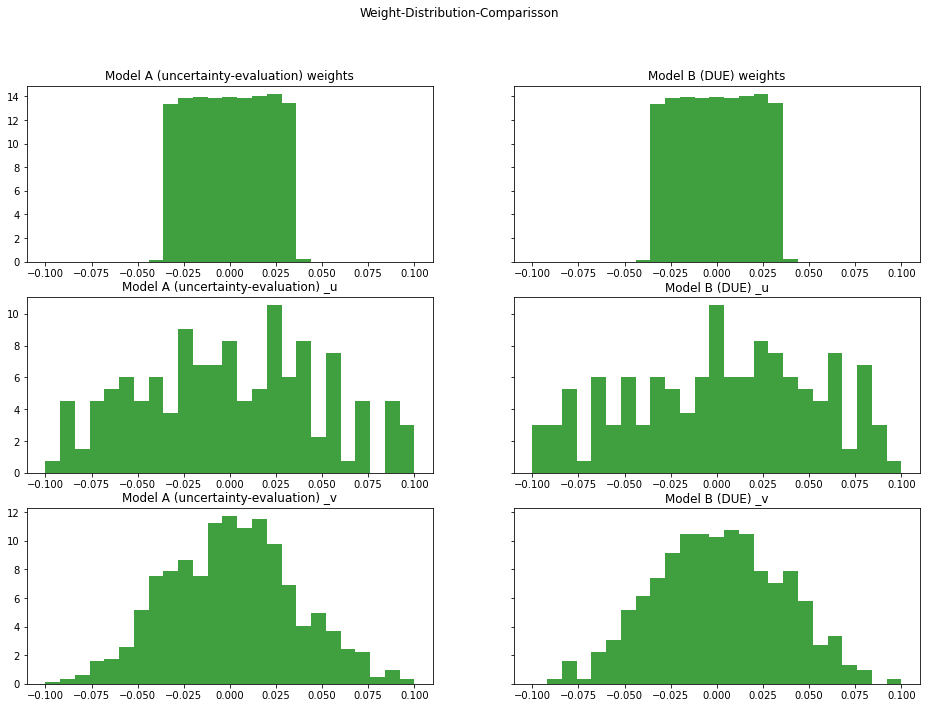

Modell A Loss: 0.3960414230823517     Modell B Loss: 0.39699554443359375


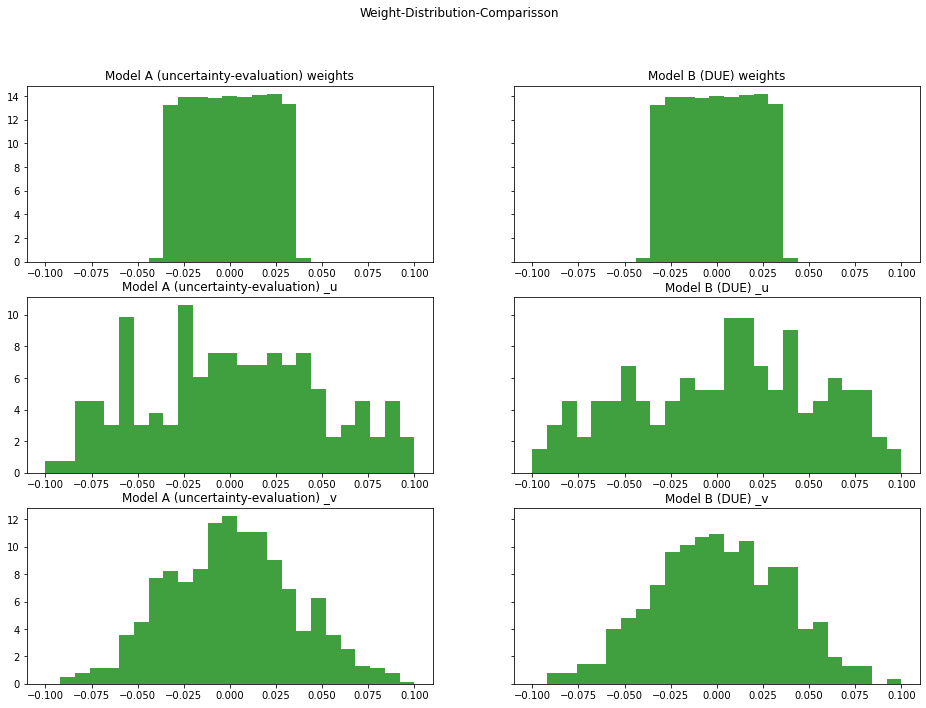

In [9]:
# Define necessary parameters and train
criterion = nn.CrossEntropyLoss()
num_out_channels = 15
num_epochs = 5
lr = 5e-3
weight_decay = 1e-5
momentum = 0.9

coeff = 0.95
n_power_iter = 1

# Define a Dataset and it's matching Loader

ds = datasets.MNIST('./ds', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))

ss = Subset(ds,[0,1000])

data_loader = torch.utils.data.DataLoader(
    ss,
    batch_size=32)

# Predefine Layers for equal param start
layer1 = nn.Linear(784, 200)
layer2 = nn.Linear(200 ,10)

# Define Models each using one of the spectral normalization variants
model_A = BasicNetA(copy.deepcopy(layer1), copy.deepcopy(layer2), coeff, n_power_iter)

optimizer_A = torch.optim.SGD(
            model_A.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum
        )

model_B = BasicNetB(copy.deepcopy(layer1), copy.deepcopy(layer2), coeff, n_power_iter)

optimizer_B = torch.optim.SGD(
            model_B.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            momentum=momentum
        )

# Train and plot loss comparisson aswell as weight distributions
num_bins = 25
hist_range = (-0.1,0.1)

for i in range(num_epochs):
    loss_A = train_one_epoch(model_A, optimizer_A, criterion, data_loader)
    loss_B = train_one_epoch(model_B, optimizer_B, criterion, data_loader)
    print("Modell A Loss:",loss_A, "    Modell B Loss:",loss_B)
    #print("Modell A Weight Norm:", model_A.show_weight_norm(), "    Modell B Weight Norm:",model_B.show_weight_norm())
    
    fig, axs = plt.subplots(
        nrows=3,
        ncols=2,
        sharey='row', 
        figsize=(16,11)
    )
    fig.suptitle('Weight-Distribution-Comparisson')

    #Original Weights
    weights_A_u = model_A.state_dict()['layer1.parametrizations.weight.original']
    weights_A_u = weights_A_u.view(weights_A_u.size(0), -1)
    weights_A_u = weights_A_u.view(1, weights_A_u.size(0)*weights_A_u.size(1))
    axs[0][0].hist(weights_A_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[0][0].title.set_text('Model A (uncertainty-evaluation) weights')
    
    weights_B_u = model_B.state_dict()['layer1.weight_orig']
    weights_B_u = weights_B_u.view(weights_B_u.size(0), -1)
    weights_B_u = weights_B_u.view(1, weights_B_u.size(0)*weights_B_u.size(1))
    axs[0][1].hist(weights_B_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[0][1].title.set_text('Model B (DUE) weights')
    

    #_u
    weights_A_u = model_A.state_dict()['layer1.parametrizations.weight.0._u']
    weights_A_u = weights_A_u.view(weights_A_u.size(0), -1)
    weights_A_u = weights_A_u.view(1, weights_A_u.size(0)*weights_A_u.size(1))
    axs[1][0].hist(weights_A_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[1][0].title.set_text('Model A (uncertainty-evaluation) _u')
    
    weights_B_u = model_B.state_dict()['layer1.weight_u']
    weights_B_u = weights_B_u.view(weights_B_u.size(0), -1)
    weights_B_u = weights_B_u.view(1, weights_B_u.size(0)*weights_B_u.size(1))
    axs[1][1].hist(weights_B_u, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[1][1].title.set_text('Model B (DUE) _u')


    #_v
    weights_A_v = model_A.state_dict()['layer1.parametrizations.weight.0._v']
    weights_A_v = weights_A_v.view(weights_A_v.size(0), -1)
    weights_A_v = weights_A_v.view(1, weights_A_v.size(0)*weights_A_v.size(1))
    axs[2][0].hist(weights_A_v, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[2][0].title.set_text('Model A (uncertainty-evaluation) _v')
    
    weights_B_v = model_B.state_dict()['layer1.weight_v']
    weights_B_v = weights_B_v.view(weights_B_v.size(0), -1)
    weights_B_v = weights_B_v.view(1, weights_B_v.size(0)*weights_B_v.size(1))
    axs[2][1].hist(weights_B_v, bins=num_bins, range=hist_range, density=True, stacked=True, facecolor='g', alpha=0.75)
    axs[2][1].title.set_text('Model B (DUE) _v')

    plt.show()